<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/Reconstruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
class Pde:
    def __init__(self, n_dim = 2, verbatim = False):
        self.n_dim = n_dim    
        self.lam = 0.
        #self.verbatim = verbatim
        if verbatim == True:
            print('>>> n_dim: '+str(n_dim))
    drift = lambda self,s,a: a
    
    run_cost = lambda self,s,a: (
            self.n_dim + sum([s1**2 for s1 in s])*2.0 
            + sum([a1**2 for a1 in a])/2.0
            )
    
    term_cost = lambda self,s: - sum([s1**2 for s1 in s])
    exact_soln = lambda self,s: - sum([s1**2 for s1 in s])


class Mdp(Pde):
    def __init__(self, n_dim = 2, n_mesh = 8, verbatim = False):
        super().__init__(n_dim, verbatim)
        self.n_mesh= n_mesh  
        self.h_mesh = 1./self.n_mesh #mesh size
        self.v_shape = tuple([self.n_mesh + 1]*self.n_dim)
        if verbatim == True:
            print('>>> n_mesh: '+str(n_mesh))


    #input: list of index
    #return: physicial coordinate
    def i2s(self,ix): 
        return [x * self.h_mesh for x in ix]
    
    def is_interior(self,ix):
        return all(map(lambda a: 0<a<self.n_mesh, ix))
        
    #input: lists of index and action
    #return: discount rate, running cost, list of next index, list of probability
    def step(self, ix, a, fd='cfd'):
        ix = list(ix)
        s = self.i2s(ix)
        b = Pde.drift(Pde, s, a)
        if fd=='cfd':
            lam = self.n_dim/(self.n_dim+self.lam*(self.h_mesh**2))
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/self.n_dim
            
            ix_next = []; pr_next= []
            #cfd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+2.*self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
        elif fd=='ufd':
            c = self.n_dim+sum([abs(b1) for b1 in b])*self.h_mesh
            b_plus = [(abs(b1)+b1)/2. for b1 in b]
            b_minus = [(abs(b1)-b1)/2. for b1 in b]
            lam = c/(c+self.h_mesh**2*self.lam)
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/c
            ix_next = []; pr_next= []
            #ufd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+2.*self.h_mesh*b_plus[i])/(c*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b_minus[i])/(c*2.0) 
                    pr_next += [pr1,]        
        return lam, run_cost_h, ix_next, pr_next
    

 
####################supplemental tools
import itertools

def deep_iter(*shape):
    iters = (range(i) for i in shape)
    return itertools.product(*iters)


#product of a list
def product(l):
    out = 1
    for x in l:
        out *= x
    return out

############  solvers

import numpy as np

class Solver(Mdp):
    def __init__(self, n_dim = 1, n_mesh = 8, fd = 'ufd', verbatim = False):
        super().__init__(n_dim, n_mesh, verbatim)
        self.fd = fd
        #value iteration init
        self.v = np.zeros(self.v_shape) #init
        self.a_space = tuple([3*n_mesh+1,]*n_dim)
        self.p_shape = tuple(list(self.v_shape)+[self.n_dim,])
        self.policy = np.zeros(self.p_shape) #init
        self.tol = 1e-5; self.max_iter = 1000
        
        #boundary value
        for ix in deep_iter(*self.v_shape):
            if not self.is_interior(ix):
                self.v[ix] = self.term_cost(self.i2s(ix))
    
    
    def i2a(self, ix):
        ix = list(ix)
        return [ix1*1./self.n_mesh for ix1 in ix]
    
    #input:
        #list of index and action
    #return:
        #q_val assuming v is value
    def q_val(self, ix, a):
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.v[tuple(ix1)]
        out *= lam
        return out
 
    #input:
        #list of index
    #return:
        #list of optimal action
        #corresponding q-value assuming v is value
    def greedy(self, ix):
        a_ix = [0,]*self.n_dim; out_v = self.q_val(ix, self.i2a(a_ix))
        for a_ix1 in deep_iter(*self.a_space):
            out_v1 = self.q_val(ix, self.i2a(a_ix1))
            if out_v1 < out_v:
                a_ix = a_ix1; out_v = out_v1
        return self.i2a(a_ix), out_v
                
        

    def value_iter(self):    
        for n_iter in range(self.max_iter):
            v_cp = np.copy(self.v)
            err = 0.
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    out_a, out_v = self.greedy(ix)
                    self.policy[ix] = out_a; self.v[ix] = out_v
                    err += (v_cp[ix]-out_v)**2

            if err<self.tol:
                break
        return err, n_iter
    
    def policy_iter(self):
        policy_stable = False
        n_iter = 0
        while not policy_stable:
            n_iter +=1
            #policy evaluation
            pe = PolicyEvaluation(self.policy, n_dim = self.n_dim, 
                                  n_mesh=self.n_mesh, fd = self.fd)
            err1, n_iter1 = pe.solver()   
            self.v = np.copy(pe.v)
            
            #policy improvement
            policy_err = 0
            policy_cp = np.copy(self.policy)
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    out_a, _ = self.greedy(ix)
                    self.policy[ix] = out_a
                    policy_err += sum(np.power(policy_cp[ix] - out_a,2))
                    
            if policy_err<1e-2:
                policy_stable = True
            if n_iter>self.max_iter:
                break
        return policy_err, n_iter
                    
###begin policy evaluation

class PolicyEvaluation(Mdp):
    def __init__(self, policy, n_dim = 1, n_mesh = 8, fd = 'ufd'):
        super().__init__(n_dim, n_mesh)
        self.fd = fd
        #value iteration init
        self.v = np.zeros(self.v_shape) #init
        self.p_shape = tuple(list(self.v_shape)+[self.n_dim,])
        self.policy = policy #init
        if not self.p_shape==np.shape(self.policy):
            print('>>>alert: policy shape is not right')
            
        self.tol = 1e-5; self.max_iter = 1000
        
        #boundary value
        for ix in deep_iter(*self.v_shape):
            if not self.is_interior(ix):
                self.v[ix] = self.term_cost(self.i2s(ix))
    
    
    #input:
        #list of index and method
    #return:
        #rhs_val assuming v is value
    def rhs_val(self, ix):
        a = self.policy[ix]
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.v[tuple(ix1)]
        out *= lam
        return out


    def solver(self):    
        for n_iter in range(self.max_iter):
            v_cp = np.copy(self.v)
            err = 0.
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    v_cp[ix] = self.rhs_val(ix)
                    err += (v_cp[ix]-self.v[ix])**2
            self.v = np.copy(v_cp)
            if err<self.tol:
                break
        return err, n_iter


###end policy evaluation


>>>>>>>check value iteration<<<<<<<<<
>>> n_dim: 1
>>> n_mesh: 32
>>>elapsed time: 4.233951091766357
>>>running err:9.806897418355369e-06 n_iter: 162
>>>>exact err:0.0014596947051310892
>>>>end check<<<<


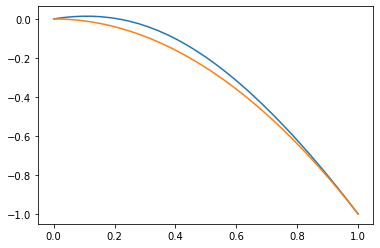

In [7]:
import time

#begin check ValueIter
print('>>>>>>>check value iteration<<<<<<<<<')

startime = time.time()
ag1 = Solver(n_dim=1, n_mesh= 32, fd='ufd', verbatim = True)
err, n_iter = ag1.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err)+' n_iter: '+ str(n_iter))

err = 0
exact_val = np.zeros(ag1.v_shape)

for ix in deep_iter(*ag1.v_shape):
    exact_val[ix] = ag1.exact_soln(ag1.i2s(list(ix)))
    err += (exact_val[ix]- ag1.v[ix])**2
err = err/product(ag1.v_shape)
    
print('>>>>exact err:'+str(err))

print('>>>>end check<<<<')


import matplotlib.pyplot as plt    

if ag1.n_dim==1:
    x_cod = np.zeros(ag1.v_shape)
    for ix in deep_iter(*ag1.v_shape):
        x_cod[ix] = ag1.i2s(list(ix))[0]
        
    plt.plot(x_cod, ag1.v, x_cod, exact_val)
    plt.show()
#end check ValueIter                

In [8]:
###begin check 
print('>>>>>>>check policy evaluation<<<<<<<<<')
starttime = time.time()
pe = PolicyEvaluation(ag1.policy, n_dim = ag1.n_dim, 
                      n_mesh=ag1.n_mesh, fd = ag1.fd)
err, n_iter = pe.solver()
endtime = time.time()

print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err)+' n_iter: '+ str(n_iter))

err = 0
for ix in deep_iter(*ag1.v_shape):
    err += (pe.v[ix]- ag1.v[ix])**2
err = err/product(ag1.v_shape)
    
print('>>>>err:'+str(err))
print('>>>>>>>end check <<<<<<<<<')
####end check######################

>>>>>>>check policy evaluation<<<<<<<<<
>>>elapsed time: 7.78818154335022
>>>running err:9.891013341387676e-06 n_iter: 336
>>>>err:2.3484694923474566e-05
>>>>>>>end check <<<<<<<<<


>>>>>>>check policy iteration vs value iteration<<<<<<<<<
>>> n_dim: 1
>>> n_mesh: 32
>>>elapsed time: 0.6402542591094971
>>>running policy err:0.009765625 n_iter: 3
>>>>value diff between value-iter and policy-iter:2.3300507725479925e-05


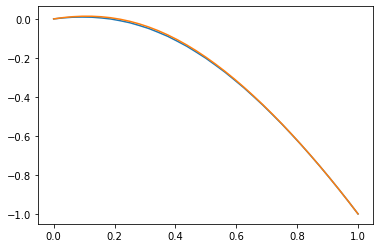

>>>end check<<<


In [9]:
#begin check policy iter, compared to value iter
print('>>>>>>>check policy iteration vs value iteration<<<<<<<<<')

startime = time.time()
ag2 = Solver(n_dim=ag1.n_dim, n_mesh= ag1.n_mesh, fd= ag1.fd, verbatim = True)
p_err, n_iter = ag2.policy_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running policy err:' +str(p_err)+' n_iter: '+ str(n_iter))

#compare value iter and policy iter 
err = 0.
for ix in deep_iter(*ag2.v_shape):
    err += (ag1.v[ix]- ag2.v[ix])**2
err = err/product(ag2.v_shape)
    
print('>>>>value diff between value-iter and policy-iter:'+str(err))


import matplotlib.pyplot as plt    

if ag2.n_dim==1:
    x_cod = np.zeros(ag2.v_shape)
    for ix in deep_iter(*ag2.v_shape):
        x_cod[ix] = ag2.i2s(list(ix))[0]
        
    plt.plot(x_cod, ag2.v, x_cod, ag1.v)
    plt.show()
    
print('>>>end check<<<')    
#end check policy iter   